# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [3]:
# Пропущенные значения бары

def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind= 'barh', figsize=(19,6), rot = -5, legend = False, fontsize = 16)
            .set_title('Пример' + "\n", fontsize = 22, color = 'SteelBlue')    
        );    
    except:
        print('пропусков не осталось :) ')

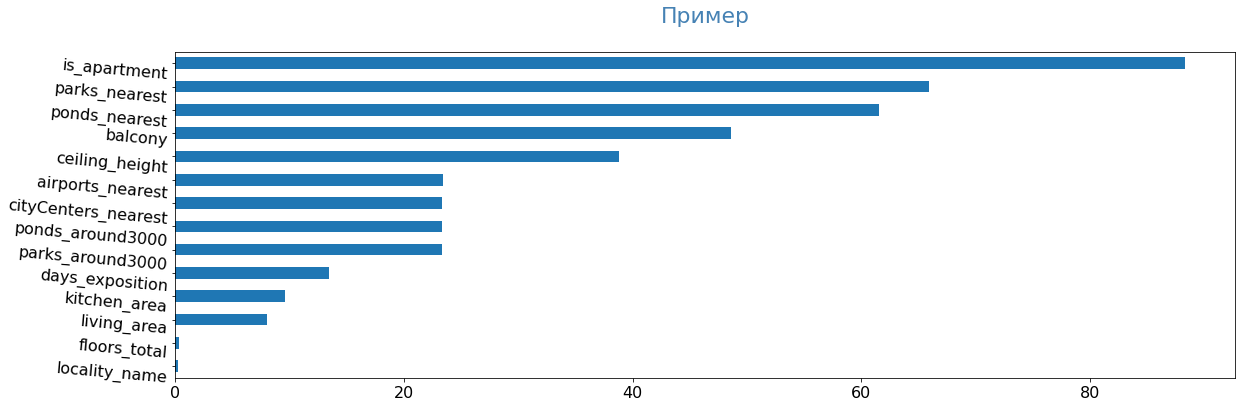

In [4]:
pass_value_barh(data)

Первый осмотр.
- Столбец first_day_exposition тип object - должен быть datetime
- Столбец ceiling_height много пропущенных значений
- Столбец living_area так же присутсвуют NaN
- Столбец is_apartment тип object - замена на boll
- Столбец kitchen_area - так же присутсвуют NaN
- Столбец balcony - так же присутсвуют NaN
- Столбец parks_nearest - есть NaN
- Столбцы parks_around3000, ponds_around3000, days_exposition - изменить тип на int. Пропущенные значения


### Предобработка данных

In [5]:
#посмотрим значения в столбцах на предмет количества совпадений всех уникальных значений.
display(data.columns)
data['total_images'].value_counts()
data['ceiling_height'].value_counts()
data['floor'].value_counts()
data['is_apartment'].value_counts()
data['total_area'].value_counts()
data['rooms'].value_counts()
data['airports_nearest'].value_counts()
data['cityCenters_nearest'].value_counts()
data['parks_around3000'].value_counts()
data['parks_nearest'].value_counts()
data['ponds_around3000'].value_counts()






Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition'],
      dtype='object')

0.0    9071
1.0    5717
2.0    1892
3.0    1501
Name: ponds_around3000, dtype: int64

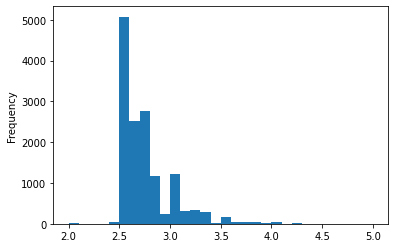

In [6]:
#изменим на тип int, так цены удобнее смотреть
data['last_price'] = data['last_price'].astype('int')
data['last_price']

# время не указано, поэтому переведем столбец в формат даты без времени
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format = '%Y-%m-%d')

#применим метод plot() для столбца data['ceiling_height'], оценим значения в нем
#имеются большие значения судя из гистограммы
#медиана от среднего не сильно отличается(скорей всего из-за выбросов по всей выборке)

data['ceiling_height'].sort_values().plot(y = 'ceiling_height', kind = 'hist', bins = 30, range=(2,5))
data['ceiling_height'].describe()
data[data['ceiling_height'] > 4].sort_values('ceiling_height').head(20)
# можно заменить все пустые значения на медиану 2,65
#data['ceiling_height'] = data['ceiling_height'].fillna('2.65')

# в floors_total- не вижу связи пропущенных значений, пока не трогаю столбец
data[data['floors_total'].isna()]

#столбец апартаменты очень странный, похоже начали его вести гораздо позже,изменю пропуски на False, 
data['is_apartment'] = data['is_apartment'].fillna(False)

#living_area есть пропущенные значения, возможно нужно будет убрать знаки посл запятой 
#можно посчитать средний процент жилой площади от всей площади по всей выборке
data['living_area'].value_counts()
data['living_area'].describe()

#заменим пропуски в balcony на 0 и поменяем тип данных на int
data['balcony'].value_counts()
data['balcony'] = data['balcony'].fillna(0)
data['balcony'] = data['balcony'].astype('int')

#не понимаю причину пропусков пока не трогаю столбец
data['locality_name'].value_counts()

#заменим пропуски в days_exposition и заменим тип данных
data['days_exposition'] = data['days_exposition'].fillna(0).astype('int')



In [7]:
# вроде разобрался с этим столбцом, сделал по-другому через функцию, без поселков и деревень. 
# Как мне кажется вид лучше и понятнее

# привел столбец locality_name к одному виду

data['locality_name'].value_counts()
data['locality_name'].unique()

bad_locality_name = data[data['locality_name'].isna()]

bad_index = bad_locality_name.index

data.drop(bad_index, inplace=True)

def short_name(row):
    split_name = row.split()
    new_name = []
    for word in split_name:
        if word[0].isupper():
            new_name.append(word)
    new_name = ' '.join(word for word in new_name)
    return new_name

    
data['short_locality_name'] = data['locality_name'].apply(short_name)

short_locality_names = data['short_locality_name'].unique()
short_locality_names


array(['Санкт-Петербург', 'Шушары', 'Янино-1', 'Парголово', 'Мурино',
       'Ломоносов', 'Сертолово', 'Петергоф', 'Пушкин', 'Кудрово',
       'Коммунар', 'Колпино', 'Красный Бор', 'Гатчина', 'Фёдоровское',
       'Выборг', 'Кронштадт', 'Кировск', 'Новое Девяткино',
       'Металлострой', 'Лебяжье', 'Сиверский', 'Молодцово',
       'Кузьмоловский', 'Новая Ропша', 'Павловск', 'Пикколово',
       'Всеволожск', 'Волхов', 'Кингисепп', 'Приозерск', 'Сестрорецк',
       'Куттузи', 'Аннино', 'Ефимовский', 'Плодовое', 'Заклинье',
       'Торковичи', 'Первомайское', 'Красное Село', 'Понтонный',
       'Сясьстрой', 'Старая', 'Лесколово', 'Новый Свет', 'Сланцы',
       'Путилово', 'Ивангород', 'Шлиссельбург', 'Никольское',
       'Зеленогорск', 'Сосновый Бор', 'Оржицы', 'Кальтино', 'Романовка',
       'Бугры', 'Рощино', 'Кириши', 'Луга', 'Волосово', 'Отрадное',
       'Павлово', 'Оредеж', 'Копорье', 'Молодёжное', 'Тихвин', 'Победа',
       'Нурма', 'Синявино', 'Тосно', 'Стрельна', 'Бокситогорск',

In [8]:
#высота потолков
ceiling_medians = data.pivot_table(index='floors_total', values='ceiling_height', aggfunc=['median', 'count'])
ceiling_medians.columns = ['median', 'count']
ceiling_medians.head()

,median,count
floors_total,,
1.0,2.80,10
2.0,2.70,213
3.0,2.80,399
4.0,3.00,787
5.0,2.55,3662


In [9]:
#заменим отсутствующие значения высоты потолков на медиану
for floor in ceiling_medians.index:
    data.loc[(data['floors_total'].isna()) | 
             ((data['floors_total'] == floor) & (ceiling_medians.loc[floor, 'count'] == 0)), 
             'ceiling_height'] = data['ceiling_height'].describe()[5]
    
for floor in ceiling_medians.index:
    data.loc[(data['ceiling_height'].isna()) & 
             (data['floors_total'] == floor), 
             'ceiling_height'] = ceiling_medians.loc[floor, 'median']

In [10]:
# check
# проверим какие аномалии остались таблица ниже
# Показатели о кол-ве объявлений в датасете, минимальных и максимальных значениях 
# в выбранных параметрах о продаже квартир
# сырые данные

(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  
          'kitchen_area', 'floor', 'floors_total']]
    .apply (['count', 'min', 'max'])   
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"23,650.00","23,650.00","23,650.00","23,650.00","23,650.00","21,752.00","21,381.00","23,650.00","23,565.00"
min,0.00,12.00,1.00,0.00,"12,190.00",2.00,1.30,1.00,1.00
max,19.00,900.00,100.00,"1,580.00","763,000,000.00",409.70,112.00,33.00,60.00


In [11]:
data['ceiling_height'] = data['ceiling_height'].replace(25, 2.5)
data['ceiling_height'] = data['ceiling_height'].replace(32, 3.2)
data['ceiling_height'].where(~(data.ceiling_height > 10), other=2.65, inplace=True)
data['ceiling_height'].where(~(data.ceiling_height < 2), other=2.65, inplace=True)
data.ceiling_height.describe()
#data.ceiling_height.unique()

count    23650.000000
mean         2.708313
std          0.244783
min          2.000000
25%          2.550000
50%          2.650000
75%          2.750000
max          8.300000
Name: ceiling_height, dtype: float64

In [12]:
data['rooms'] = data['rooms'].fillna(0)
data['rooms']= data.query('rooms <14')['rooms']


In [13]:
# check
data.rooms.value_counts().to_frame()


,rooms
1.0,8036
2.0,7924
3.0,5797
4.0,1175
5.0,326
0.0,197
6.0,105
7.0,59
8.0,12
9.0,8


In [14]:
data['kitchen_area'] = data['kitchen_area'].fillna(0)
data['kitchen_area'].where(~(data.kitchen_area < 5), other=5, inplace=True)
data['kitchen_area'].astype('int')

0        25
1        11
2         8
3         5
4        41
         ..
23694    13
23695     8
23696     5
23697    23
23698     9
Name: kitchen_area, Length: 23650, dtype: int64

In [15]:
data['living_area'] = data['living_area'].fillna(0)
data['living_area'] = data['living_area'].astype('int')


In [16]:
# check
data.rooms.value_counts().to_frame()

,rooms
1.0,8036
2.0,7924
3.0,5797
4.0,1175
5.0,326
0.0,197
6.0,105
7.0,59
8.0,12
9.0,8


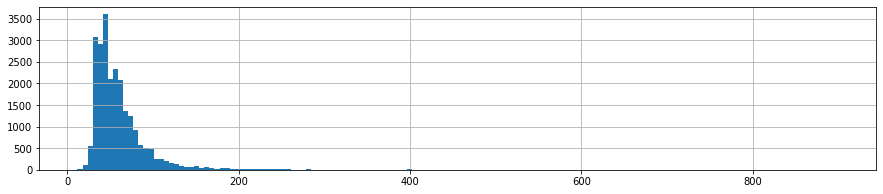

In [17]:
# check
data.total_area.hist(bins = 150, figsize = (15,3));


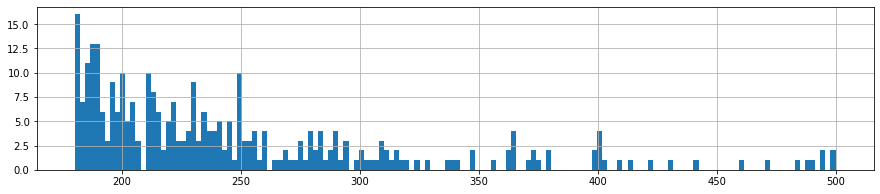

In [18]:
# check
data.total_area.hist(bins = 150, figsize = (15,3), range = (180,500));

Все квартиры более двухсот квадратных метров можно считать редкостями
        
особенно это заметно на втором графике, где мы подробно рассматриваем промежуток от 180 кв. метров до 500

In [19]:

# data['total_area'] = data.query('total_area < 180')

data = data.query('total_area < 180')


display(data.info())
data['total_area'] = data['total_area'].astype('int')
data['floors_total'].describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23334 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23334 non-null  int64         
 1   last_price            23334 non-null  int64         
 2   total_area            23334 non-null  float64       
 3   first_day_exposition  23334 non-null  datetime64[ns]
 4   rooms                 23334 non-null  float64       
 5   ceiling_height        23334 non-null  float64       
 6   floors_total          23250 non-null  float64       
 7   living_area           23334 non-null  int64         
 8   floor                 23334 non-null  int64         
 9   is_apartment          23334 non-null  bool          
 10  studio                23334 non-null  bool          
 11  open_plan             23334 non-null  bool          
 12  kitchen_area          23334 non-null  float64       
 13  balcony         

None

count    23250.000000
mean        10.725978
std          6.606490
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

In [20]:
data['floors_total'] = data.query('floors_total < 60')
data.dropna(subset=['floors_total'], inplace=True)
data['floors_total'] = data['floors_total'].astype('int')
data['floors_total'].head()

0    20
1     7
2    10
3     0
4     2
Name: floors_total, dtype: int64

#### check r.3.1

In [21]:
# check
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23249 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23249 non-null  int64         
 1   last_price            23249 non-null  int64         
 2   total_area            23249 non-null  int64         
 3   first_day_exposition  23249 non-null  datetime64[ns]
 4   rooms                 23249 non-null  float64       
 5   ceiling_height        23249 non-null  float64       
 6   floors_total          23249 non-null  int64         
 7   living_area           23249 non-null  int64         
 8   floor                 23249 non-null  int64         
 9   is_apartment          23249 non-null  bool          
 10  studio                23249 non-null  bool          
 11  open_plan             23249 non-null  bool          
 12  kitchen_area          23249 non-null  float64       
 13  balcony         

In [22]:
# check

# Значения параметров объектов недвижимости на разных квантилях

(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  
        'kitchen_area', 'floor',   'floors_total']]
    .quantile([0.01, .5, .90, .976])  
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
0.01,1.00,25.00,2.50,0.00,"1,000,000.00",0.00,5.00,1.00,0.00
0.5,2.00,51.00,2.65,73.00,"4,600,000.00",29.00,8.90,4.00,9.00
0.9,3.00,90.00,3.00,422.00,"10,300,000.00",52.00,15.00,13.00,18.00
0.976,4.00,128.00,3.30,803.05,"18,500,000.00",76.00,23.30,20.00,20.00


### Посчитайте и добавьте в таблицу новые столбцы

In [23]:
#посчитаем цену квадратного метра и переведем к типу int удобнее станет

data['price_per_square_meter'] = data['last_price'] / data['total_area']

data['price_per_square_meter'] = data['price_per_square_meter'].fillna(0).astype('int')
data['price_per_square_meter'].describe()
# data['price_per_square_meter']

count      23249.000000
mean       98524.412878
std        43006.854819
min          111.000000
25%        76785.000000
50%        95238.000000
75%       114285.000000
max      1000000.000000
Name: price_per_square_meter, dtype: float64

In [24]:
#делаем столбцы день месяц и год
data['weekday_exposition'] = data['first_day_exposition'].dt.weekday

data['month_exposition'] = data['first_day_exposition'].dt.month

data['year_exposition'] = data['first_day_exposition'].dt.year

In [25]:
#напишем функцию для типа этажа квартиры, используя метод apply применимо к каждой строке датафрейма через axis = 1
def floor_category(row):
    floors_total = row['floors_total']
    floor = row['floor']
    if floor == 1:
        return 'первый'
    elif floor == floors_total:
        return 'последний'
    elif 1 < floor < floors_total:
        return 'другой'
    
#категоризуем этажи с помощью функции  
data['floor_category'] = data.apply(floor_category, axis = 1)

In [26]:
#столбец расстояния до центра города в км и округлим до целых значений тип Int
data['cityCenters_nearest_km'] = data['cityCenters_nearest']/1000
data['cityCenters_nearest_km'] = data['cityCenters_nearest_km'].fillna(0).astype('int')
data['cityCenters_nearest_km']

0        16
1        18
2        13
3         6
4         8
         ..
23694     4
23695     0
23696     0
23697    10
23698     0
Name: cityCenters_nearest_km, Length: 23249, dtype: int64

### Проведите исследовательский анализ данных

count    23249.000000
mean        57.422814
std         25.305028
min         12.000000
25%         40.000000
50%         51.000000
75%         68.000000
max        179.000000
Name: total_area, dtype: float64

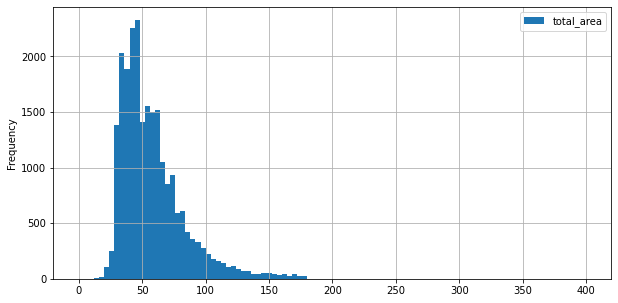

In [27]:
#общая площадь
data.plot(y = 'total_area', kind = 'hist', bins = 100, grid=True, figsize = (10,5), range = (0,400))
data['total_area'].describe()
#распределение данных нормальное, Общая площадь в нашей выборке колеблется от 12 до 900 м2, 
#среднее значение 60, а медиана 52 м2. Распределение данных Гаусса.
#по гистограмме кроме распределения нечего больше указать
#с помошью describe получил общее представление по площадям

count    23249.000000
mean        30.158717
std         18.307083
min          0.000000
25%         17.000000
50%         29.000000
75%         40.000000
max        140.000000
Name: living_area, dtype: float64

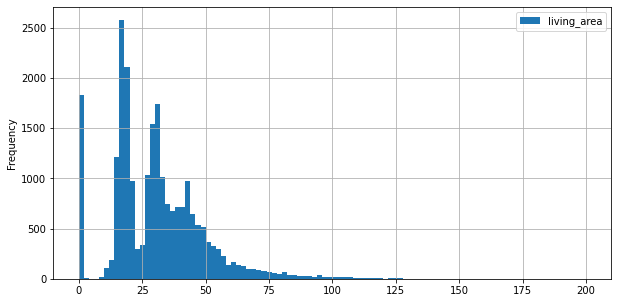

In [28]:
#жилая площадь
data.plot(y = 'living_area', kind = 'hist', bins = 100, grid=True, figsize = (10,5), range = (0,200))
data['living_area'].describe()

count    23249.000000
mean         9.836080
std          5.245001
min          5.000000
25%          6.300000
50%          8.900000
75%         11.240000
max         93.000000
Name: kitchen_area, dtype: float64

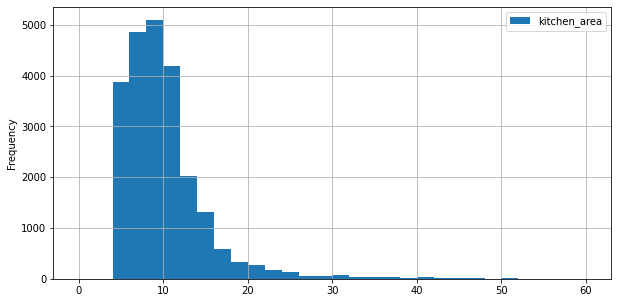

In [29]:
#посмотрим на площадь кухни
data.plot(y = 'kitchen_area', kind = 'hist', bins = 30, grid=True, figsize = (10,5), range = (0,60))

data['kitchen_area'].describe()

count    2.324900e+04
mean     5.909462e+06
std      5.250135e+06
min      1.219000e+04
25%      3.400000e+06
50%      4.600000e+06
75%      6.650000e+06
max      1.350000e+08
Name: last_price, dtype: float64

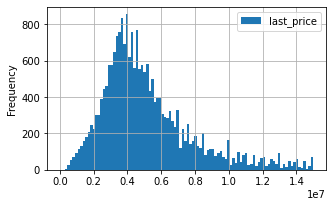

In [30]:
#изучим цену
#data['last_price'] = data['last_price']/1000000
data.plot(y = 'last_price', kind = 'hist', bins = 100, grid=True, range = (0,15000000), figsize = (5,3))
data['last_price'].describe()
#с данными все впорядке но значения выводятся в экспоненциальной записи чисел

count    23249.000000
mean         2.024302
std          0.978416
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          8.000000
Name: rooms, dtype: float64

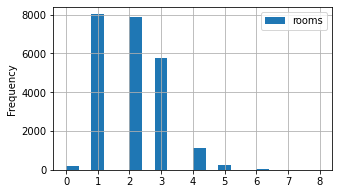

In [31]:
#посмотрим число комнат
data.plot(y = 'rooms', kind = 'hist', bins = 20, grid=True, figsize = (5,3))
data['rooms'].describe()


count    23249.000000
mean         2.702298
std          0.233230
min          2.000000
25%          2.550000
50%          2.650000
75%          2.750000
max          8.300000
Name: ceiling_height, dtype: float64

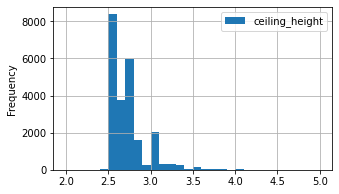

In [32]:
#изучим высоту потолков
data.plot(y = 'ceiling_height', kind = 'hist', bins = 30, range = (2,5), grid=True, figsize = (5,3))
data['ceiling_height'].describe()
#с данными все впорядке

count    23249.000000
mean         5.889888
std          4.882295
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64

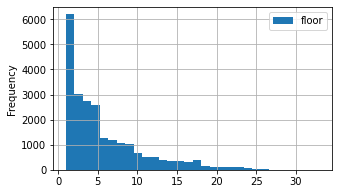

In [33]:
#изучим этаж квартиры
data.plot(y = 'floor', kind = 'hist', bins = 30, grid=True, figsize = (5,3))
data['floor'].describe()

<AxesSubplot:>

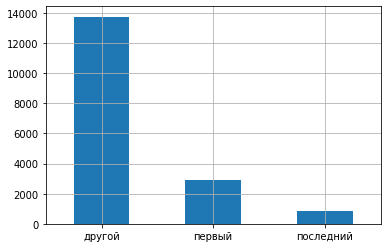

In [34]:
#тип этажа квартиры
#data['floor_category'].head()

data["floor_category"].value_counts().plot.bar(rot=0, grid=True)


count    23249.000000
mean         9.845284
std          5.658848
min          0.000000
25%          6.000000
50%          9.000000
75%         14.000000
max         50.000000
Name: floors_total, dtype: float64

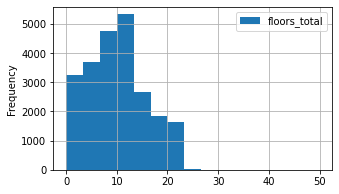

In [35]:
# общее количество этажей в доме
data.plot(y = 'floors_total', kind = 'hist', bins = 15, range = (0,50), grid=True, figsize = (5,3))
data['floors_total'].describe()

count    17755.000000
mean     14309.803830
std       8583.244028
min        181.000000
25%       9488.000000
50%      13170.000000
75%      16322.500000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

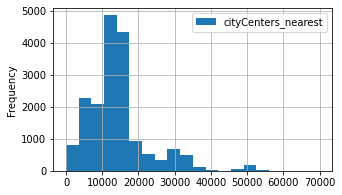

In [36]:
#расстояние до центра города
data.plot(y = 'cityCenters_nearest', kind = 'hist', bins = 20, range = (0,70000), grid=True, figsize = (5,3))
data['cityCenters_nearest'].describe()

count    17735.000000
mean     28826.796617
std      12687.376561
min          0.000000
25%      18488.000000
50%      26871.000000
75%      37366.000000
max      84869.000000
Name: airports_nearest, dtype: float64

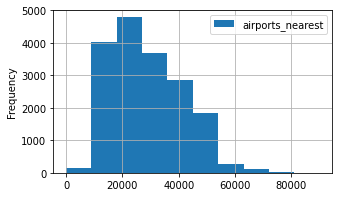

In [37]:
#расстояние до ближайшего аэропорта
data.plot(y = 'airports_nearest', kind = 'hist', bins =10, range = (0,90000), grid=True, figsize = (5,3))
data['airports_nearest'].describe()

count    7824.000000
mean      491.325792
std       340.848298
min         1.000000
25%       288.000000
50%       456.000000
75%       613.000000
max      3190.000000
Name: parks_nearest, dtype: float64

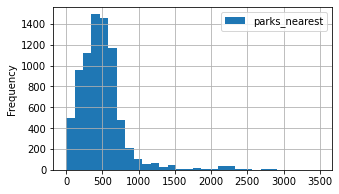

In [38]:
#расстояние до ближайшего парка
data.plot(y = 'parks_nearest', kind = 'hist', bins =30, range = (0,3500), grid=True, figsize = (5,3))
data['parks_nearest'].describe()

count    23249.000000
mean         6.402168
std          3.492469
min          1.000000
25%          3.000000
50%          6.000000
75%         10.000000
max         12.000000
Name: month_exposition, dtype: float64

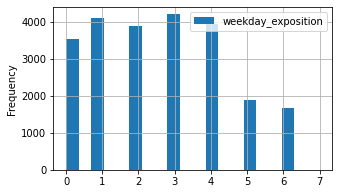

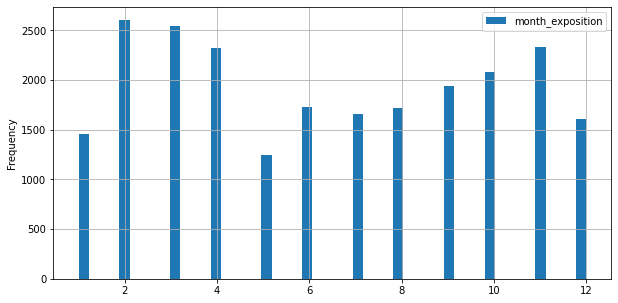

In [39]:
#день и месяц публикации объявления

data.plot(y = 'weekday_exposition', kind = 'hist', bins =20, range = (0,7), grid=True, figsize = (5,3))
data['weekday_exposition'].describe()

data.plot(y = 'month_exposition', kind = 'hist', bins =50, range = (1,12), grid=True, figsize = (10,5))
data['month_exposition'].describe()

# Выводы по гистограммам 
- Во всех данных есть неадекватные значения, такие как 0 комнат, высоты потолков в 1 или 100 метров, цен на квартире в районе 12 тысяч. Возможно не правильная была выгрузка данных.

- Общая площадь в нашей выборке колеблется от 12 до 900 м2, среднее значение 60, а медиана 52 м2. Распределение данных Гаусса.
- Жилая площадь в диапазоне от 2 до 409 квадратов, среднее значение 34, медиана 52
- Площадь кухни находится в дипазоне 1,3 - 112 м2. Средняя 10м2, медиана 9м2 Распределение данных Гаусса.
- Цены на недвижимость имеют среднее значение в 6,5 млн руб., медиана 4,6 млн руб. Распределение данных Гаусса.
- Количество комнат колеблется от 1 до 19. Больше всего однокомнатных квартир.
- Высота потолков в среднем составляет 2,77 м, медиана 2,65 м.
- этажи квартир максимальное количество этажей 33, среднее 5 этажей, по медиане 4.
- Тип этажа квартиры больше "другой" чем первый или последний
- количество этажей в доме до 60 этажей. Среднее значение 10. Медиана 9 этажей
- расстояние до центра города в метрах до центра расстояние от 181 метра до 66км. В среднем 15 км. Медиана 13км
- расстояние до ближайшего аэропорта максимально 85 км. Среднее расстояние 28 км, по медиане 26 км.
- расстояние до ближайшего парка а вот с парками дела лучше обстоят, среднее расстояние до парка 490метров, медиана 455 метров.
- день и месяц публикации объявления публикация обьявлений в будние дни большая часть середина недели Среда. К выходным реже, в воскресенье публикаций не было. С февраля рост публицаций, в мае спад и до ноябре снова повышение. В декабре и на январь уже ничинается снижение.



45      879
60      538
7       233
30      206
90      187
       ... 
1240      1
1112      1
1080      1
1064      1
1391      1
Name: days_exposition, Length: 1128, dtype: int64

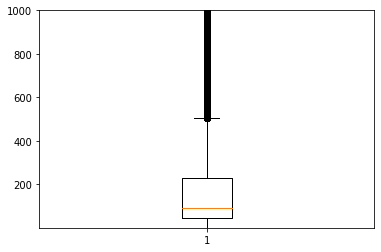

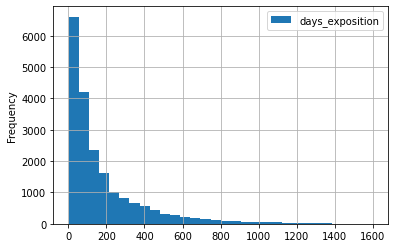

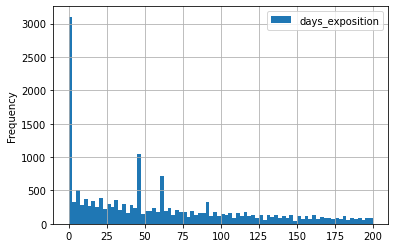

In [40]:
#как быстро идет продажа квартир
plt.boxplot(data[data['days_exposition']!=0]['days_exposition'])
plt.ylim(1,1000)

data.plot(y = 'days_exposition', kind = 'hist', bins = 30, grid = True, range = (1,1600))
data.plot(y = 'days_exposition', kind = 'hist', bins = 80, grid = True, range = (0,200))

#среднее значение, медиана и межквартильный размах
data[data['days_exposition']!=0]['days_exposition'].describe()
data[data['days_exposition']!=0]['days_exposition'].value_counts()

- Вывод
- Получили распределение Пуассона. Среднее значение - 180 дней, а медиана - 95 дней. А если построить гистограмму со значениями от 0 до 200 с кол-вом корзин 80, увидим выбивающиеся значения, методом value_counts подтверждаем - у нас аномалии на 45, 60, 7, 30, 90 днях - это наиболее популярное количество дней до снятия объявления. Возможно после этих дней обьявления автоматически снимаются с продажи.

0.7124900464937272

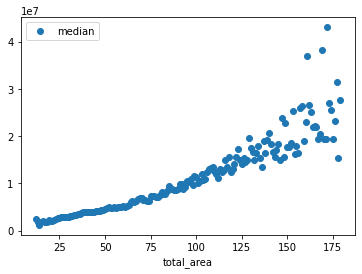

In [41]:
#факторы влияющие на полную стоимость квартиры

#посчитаем зависимость цены от общей площади
pivot_table_total_area = data.pivot_table(index = 'total_area',
                                          values = 'last_price',
                                          aggfunc = ['mean', 'count', 'median'])
pivot_table_total_area.columns = ['mean', 'count', 'median']
pivot_table_total_area.plot(y = 'median', style = 'o')

pivot_table_total_area.sort_values('median', ascending = False)

data['total_area'].corr(data['last_price'])

Корреляция Пирсона 0,65, что говорит о линейной взаимосвязи с ростом площади растет и цена.


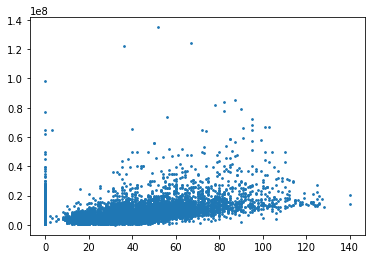

In [42]:
# зависимость цены от жилой площади
pivot_table_total_area = data.pivot_table(index = 'living_area',
                                          values = 'last_price',
                                          aggfunc = ['median'])
pivot_table_total_area.columns = ['median']


pivot_table_total_area.sort_values('median', ascending = False)

#data['last_price'].corr(data['living_area'])
plt.scatter(data['living_area'], data['last_price'], marker='o', s=3)

Корреляция Пирсона 0,5, что говорит о линейной взаимосвязи с ростом жилой площади растет и цена.

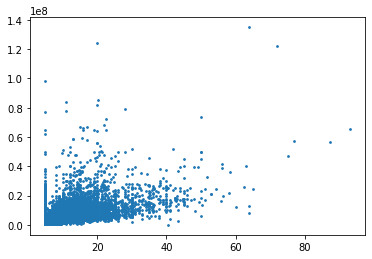

In [43]:
# зависимость цены от площади кухни
pivot_table_total_area = data.pivot_table(index = 'kitchen_area',
                                          values = 'last_price',
                                          aggfunc = ['median'])
pivot_table_total_area.columns = ['median']

pivot_table_total_area.sort_values('median', ascending = False)

#data['kitchen_area'].corr(data['last_price'])
plt.scatter(data['kitchen_area'], data['last_price'], marker='o', s=3)

Корреляция Пирсона не большая 0,5, что говорит о незначительной зависимости цены от площади кухни


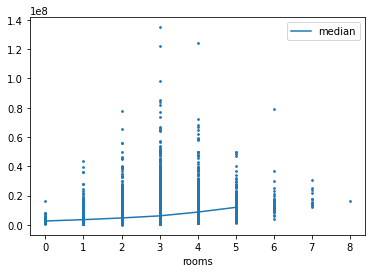

In [44]:
#количество комнат
pivot_table_rooms = data.pivot_table(index = 'rooms', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
pivot_table_rooms.columns = ['mean', 'count', 'median']
pivot_table_rooms.query('count > 50').plot(y = 'median')

pivot_table_rooms.query('count < 50').sort_values('median', ascending = False)

#data['last_price'].corr(data['rooms'])
plt.scatter(data['rooms'], data['last_price'], marker='o', s=3)

По данному графику видно что наибольшая цена идет от 3х до 5 комнат.

,mean,count,median
floor_category,,,
другой,6.207357e+06,13746,4800000
первый,4.603186e+06,2889,3900000
последний,5.743041e+06,882,4600000


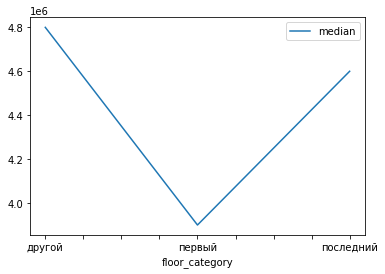

In [45]:
#зависимость от этажа
pivot_table_floor_category = data.pivot_table(index = 'floor_category', values = 'last_price',aggfunc = ['mean', 'count', 'median'])
pivot_table_floor_category.columns = ['mean', 'count', 'median']
pivot_table_floor_category.plot(y = 'median')
pivot_table_floor_category


Самые дорогие квартиры получаются из категории Другие, т.е первый и последний этаже дешевле. Но самый дешевый этой первый этаж.

,mean,count,median
weekday_exposition,,,
1,5.951204e+06,4121,4700000
2,5.876213e+06,3883,4650000
0,5.939899e+06,3553,4600000
3,6.130432e+06,4203,4600000
4,5.795438e+06,3933,4500000
5,5.834390e+06,1896,4500000
6,5.614885e+06,1660,4500000


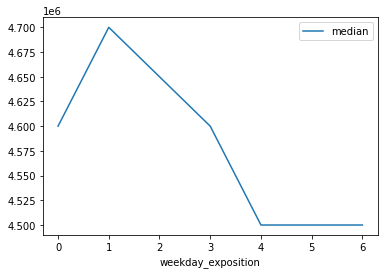

In [46]:
# зависимость от дня недели
pivot_table_weekday_exposition = data.pivot_table(index = 'weekday_exposition',
                                                  values = 'last_price',
                                                  aggfunc = ['mean', 'count', 'median'])
pivot_table_weekday_exposition.columns = ['mean', 'count', 'median']
pivot_table_weekday_exposition.plot(y = 'median')

pivot_table_weekday_exposition.sort_values('median', ascending = False)

К вторнику идет рост в цене, снижение стоимости к выходным

,mean,count,median
month_exposition,,,
4,5.919376e+06,2325,4755000
9,5.981155e+06,1944,4650000
11,5.986231e+06,2330,4650000
12,6.106604e+06,1613,4650000
2,6.003955e+06,2605,4600000
3,5.738878e+06,2542,4600000
7,5.865100e+06,1656,4600000
1,5.944930e+06,1461,4575000
8,5.956904e+06,1721,4550000


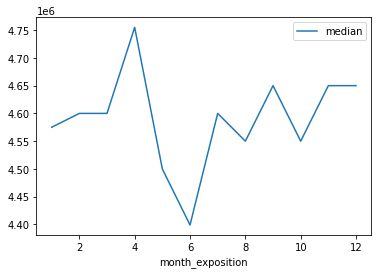

In [47]:
# зависимость от месяца
pivot_table_weekday_exposition = data.pivot_table(index = 'month_exposition',
                                                  values = 'last_price',
                                                  aggfunc = ['mean', 'count', 'median'])
pivot_table_weekday_exposition.columns = ['mean', 'count', 'median']
pivot_table_weekday_exposition.plot(y = 'median')

pivot_table_weekday_exposition.sort_values('median', ascending = False)

 Самая высокая стоимость апрель. Самая низкая стоимость в мае. Сезонность(количество спроса) влияет и на рынок недвижимости.

,mean,count,median
year_exposition,,,
2014,1.067378e+07,131,7500000
2015,7.165365e+06,1131,5200000
2019,6.318811e+06,2844,5000000
2018,5.594605e+06,8403,4538000
2016,6.030617e+06,2703,4500000
2017,5.798664e+06,8037,4499000


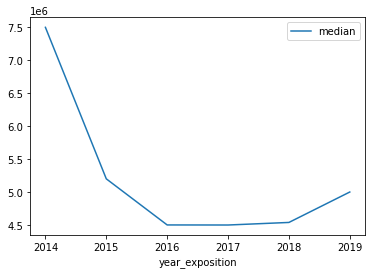

In [48]:
pivot_table_year_exposition = data.pivot_table(index = 'year_exposition',
                                               values = 'last_price',
                                               aggfunc = ['mean', 'count', 'median'])
pivot_table_year_exposition.columns = ['mean', 'count', 'median']
pivot_table_year_exposition.plot(y = 'median')

pivot_table_year_exposition.sort_values('median', ascending = False)

С 2014 года идет снижение цены вплоть до 2016 года. В дальнейшем идет постепенное увеличение стоимости. В 2014 году сервисом пользовалась лишь малая часть людей, стоимость недвижимости у которых была выше средней по рынку (и медиана выше), а в последующие годы «подтянулся» массовый продавец и цена пополза вниз...

In [49]:
locality_pivot_table = data.pivot_table(index = 'locality_name', values = 'price_per_square_meter', aggfunc=['count', 'mean'])
locality_pivot_table.columns = ['count', 'mean']
locality_pivot_table = locality_pivot_table.sort_values('count', ascending = False).head(10)
locality_pivot_table
#самая высокая стоимость
#locality_pivot_table[locality_pivot_table['mean']==locality_pivot_table['mean'].max()]
#самая низкая стоимость
#locality_pivot_table[locality_pivot_table['mean']==locality_pivot_table['mean'].min()]

,count,mean
locality_name,,
Санкт-Петербург,15358,113616.019273
посёлок Мурино,520,86298.390385
посёлок Шушары,439,78943.056948
Всеволожск,398,68984.801508
Пушкин,363,103540.068871
Колпино,337,75644.335312
посёлок Парголово,326,90832.819018
Гатчина,307,69045.068404
деревня Кудрово,299,93001.742475


Самая высокая стоимость квартир из 10 населённых пунктов с самым большим количеством объявлений в Санкт-Петербурге, а самая низкая стоимость в Выборге.

,last_price
cityCenters_nearest_km,
0,1.510328e+07
1,1.205890e+07
2,1.194674e+07
3,1.019894e+07
4,1.134743e+07
5,1.163901e+07
6,1.233496e+07
7,1.054619e+07
8,8.220066e+06


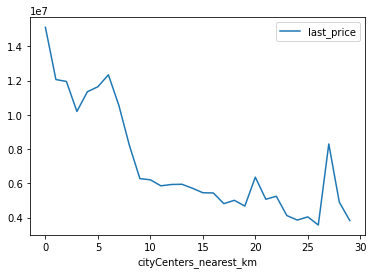

In [50]:
#средняя цена каждого километра квартир в Санкт-Петербурге
pivot_table_km_city_center = data.query('locality_name == "Санкт-Петербург" and cityCenters_nearest_km !=1000000')\
.pivot_table(index = 'cityCenters_nearest_km',
                                                                                                                               values = 'last_price',
                                                                                                                               aggfunc = 'mean')
pivot_table_km_city_center.plot()
pivot_table_km_city_center.head(10)

Судя по данным - стоимость квадратоного метра уменьшается чем дальше от центра.

### Общий вывод

Произвел обработку пропущенных значений где было необходимо, изменил тип данных для более удобной работы с ними
Посчитал и добавил в таблицу цену квадратного метра жилья, добавил из даты дни недели, месяцы и года размещения, добавил категории по этажам квартир. 
Изучая время продажи квартир выявил, большое количество объявлений скорей всего было снято автоматически с продажи, поэтому это время не учитывалось, среднее время составило 180 дней, медиана 95.С помощью диаграммы размаха, выявил что нормальные значения продажи квартир варьируются от 1 до 550(600) днейй. Так же на стоимость квадратного метра больше всего влияют жилая площадь, количество комнат, этаж квартиры. Незначительно на стоимость квадратного метра влияют день, месяц, год размещения. Сезонность не мало важный фактор в продажах недвижимости. Так же чем ближе к центру стоиомсть квадратного метра увеличивается.С 2014 года по 2016 год было снижение стоимостью жилья, с последующим увеличением. 
В целом мы смотрели средние показатели по рынку недвижимости за промежуток времени(2014-2019 года)




### Итоговый вывод

Основным параметром для определения стоимости квартиры - это стоимость квадратного метра.
Даты продаж позволят определить, в какой момент лучше продвигать рекламную компанию по продаже домов. В какие месяцы или дни недели. Количество продаж по годам имеет естественную зависимость от количество жителей города.
Этажи квартир. Наиболее сильная корреляция наблюдается между площадью квартиры и ее стоимостью (коэфф. корреляции 0,65).
Так же коэффициент корреляции 0,5 находится при соотношении общей стоимости и жилой площади что логично, чем больше жилая площадь тем и выше зависимости по цене.
Стоимость квартиры также напрямую зависит от числа комнат: чем их больше, тем квартира дороже. Но это верно, пока число комнат не превышает четырех: 5- или 6-комнатные квартиры могут быть проданы дешевле 4-комнатных, и вызвано это скорее всего отсутствием спроса.
Квартиры на первом или последнем этаже обычно продаются по более низкой цене, чем квартиры на других этажах.

Пригороды к Санкт-Петербургу имеют тенденцию к снижению цен за квартиру ввиду отсуствия престижа.
Центр города место одно из самых больших по стоимости квартир.


